<h3>Predictors of Non-Voters in the United States</h3>

To-do:
* get accuracy rate for each method
* use toy data (iris) to prove our method works
* write up paper

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from numpy import linalg as la
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv('no_voter_data.csv')

<h4>Data Cleaning and Manipulation

In [3]:
# create necessary columns for race 
df['white'] = np.where(df['race'] == 'White', 1, 0)
df['black'] = np.where(df['race'] == 'Black', 1, 0)
df['other/mixed'] = np.where(df['race'] == 'Other/Mixed', 1, 0)
df['hispanic'] = np.where(df['race'] == 'Hispanic', 1, 0)

In [4]:
# gender 
df['gender'] = np.where(df['gender'] == 'Female', 1, 0)

In [5]:
# income category
new_label = {"income_cat": {"Less than $40k":1, 
            "$40-75k":2, 
            "$75-125k":3,
            "$125k or more":4}}
df.replace(new_label, inplace = True)

In [6]:
# education category
new_label = {"educ": {"High school or less":1, 
            "Some college":2, 
            "College":3}}
df.replace(new_label, inplace = True)

In [7]:
# voter category data manipulations
new_label = {"voter_category": {"always":3, "sporadic":2, "rarely/never":1}}
df.replace(new_label, inplace = True)

In [8]:
# DROPPP
df = df.drop(["race", "RespId", "weight"], axis=1)
# fill NA's 
df_2 = df.fillna(0)

In [9]:
y = df_2["voter_category"]

In [10]:
X = df_2.drop("voter_category", axis=1)

<h4>Create train and test data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h4> Method 1: Truncated SVD

In [13]:
# Truncated SVD
# use different # of cols and find which # minimizes error
def truncated_svd(X, y):
    svd_errors = []
    w_hats_svd = []
    _, p = X.shape
    u, s, vt = la.svd(X)
    sigma = np.zeros(X.shape)
    sigma1 = sigma.copy()

    for i in range(p):
        s1 = s[:i+1]
        np.fill_diagonal(sigma, np.append(s1, np.zeros(p - i + 1)))
        sigma_inv = la.pinv(sigma)
        w_hat_svd = vt.T@sigma_inv@u.T@y
        w_hats_svd.append(w_hat_svd)
        y_hat_svd = X@w_hat_svd
        svd_errors.append(np.mean(y - y_hat_svd)**2)

    best_param_svd = svd_errors.index(min(svd_errors))
    return best_param_svd, w_hats_svd[best_param_svd]

In [14]:
svd_best_num_col, svd_whats = truncated_svd(X_train, y_train)

In [15]:
svd_best_num_col

117

<h4> Method 2: Ridge Regression

In [16]:
# Ridge Regression
def rls(X, y, lambda_vals):
    
    #### RLS ####
    w_hat_lst = []
    errors_lst = []
    u, s, vt = la.svd(X)
    sigma = np.zeros(X.shape) # n x p
    sigma1 = sigma.copy() #creating copy 
    np.fill_diagonal(sigma1, s)
            
    for l, val in enumerate(lambda_vals):
        w_hat = la.inv(vt.T@sigma1.T@sigma1@vt + val)@vt.T@sigma1.T@u.T@y
        w_hat_lst.append(w_hat)

        y_tilde = X@w_hat
        # error = la.norm(y - y_tilde)
        error = np.mean((y_tilde - y)**2)
        errors_lst.append(error)

    best_param_index = errors_lst.index(min(errors_lst))
    best_w = w_hat_lst[best_param_index]
    best_lambda = lambda_vals[best_param_index]
    return best_lambda, best_w 


In [19]:
lambda_vals = np.array([0, 0.001, 0.01, 0.1, 0.5, 1, 2, 4, 8, 16, 32, 64])

rls_best_lambda, rls_whats = rls(X, y, lambda_vals)

In [22]:
print(rls_best_lambda)

0.01


<h4> Method 3: Principal Component Analysis

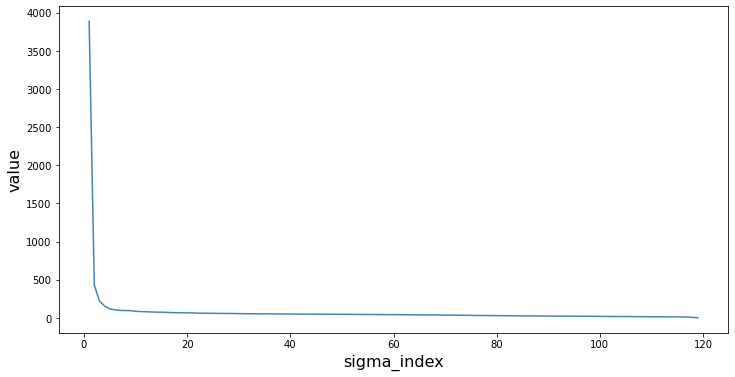

In [23]:
# PCA
u,s,vh = np.linalg.svd(X_train ,full_matrices=False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(range(1,s.shape[0]+1), s, color="steelblue", label='sigmas')
ax.set_xlabel("sigma_index", fontsize=16)
ax.set_ylabel("value", fontsize=16)
plt.show()

# first 3 sigmas seem to be the most important; we will solve for 3 principle components

In [24]:
# calculate principal components
pc = X_train@vh[:3,:].T
z3 = pc

# use 3 PC to compute least sqaures 
w = np.linalg.inv(z3.T@z3)@z3.T@y_train
y_pred = z3@w
acc_train = np.mean((y_pred - y_train)**2)
acc_train = la.norm(y_pred - y_train)
print("training error distance:", acc_train)

# What to make of this? 

training error distance: 50.142760706404516


<h4> Method 4: Kernal Ridge

In [71]:
# Kernal Ridge
def kernel_ridge(X, y, X_test, sigma, lam):
    n, p = X.shape
    ntest, ptest = X_test.shape
    norms2 = (np.array(la.norm(X, axis =1)).T)**2 # squared norm of each training sample
    innerProds = X@X.T

    # squared distances between each pair of training samples
    dist2 = np.matrix(norms2).T@np.ones([1, n]) + np.ones([n, 1])@np.matrix(norms2) - 2*innerProds 
    K = np.exp(-dist2/(2*sigma))
    alpha = (la.inv(K + lam*np.identity(n))@y)
    yhat = K@alpha.T
    

    norms2_test = (np.array(la.norm(X_test, axis =1)).T ) **2
    innerProds_test = X_test@X_train.T
    dist2_test = np.matrix(norms2_test).T@np.ones([1 , n]) + np.ones ([ntest ,1])@np.matrix(norms2) -2* innerProds_test
    k_test = np.exp(-dist2_test/(2*sigma))
    y_hat = np.rint(k_test@alpha.T)
    
    return alpha, y_hat

In [82]:
# initial sigma/lam
sigma = 50
lam = 1
kr_alpha, kr_y_hat = kernel_ridge(X_train, y_train, X_test, sigma, lam)

In [83]:
sum(kr_y_hat)

2325.0

In [18]:
# calculate accuracy all methods
def accuracy(y_hat, y_test):
    return np.mean(y_hat==y_test)

In [205]:
accuracy(kr_y_hat, y_test)

0.5556506849315068

<h4> Method 5 (beyond class): Logistic Regression

In [ ]:
# Logistic Regression

In [177]:
def sigmoid(score, threshold=20.0):
    """
    Sigmoid function with a threshold
    :param score: (float) A real valued number to convert into a number between 0 and 1
    :param threshold: (float) Prevent overflow of exp by capping activation at 20.
    
    :return: (float) sigmoid function result.
    """
    # TODO: Finish this function to restrict the value of the input score and return the output of applying the 
    #       sigmoid function to it (Please do not use external libraries)
    
    if abs(score) > abs(threshold):
        score = math.copysign(threshold,score)

    sigmoid = 1 / (1 + math.exp(-score))
    
    return sigmoid

    
def sigmoid_grad(y, threshold=20.0):
    """
    Derivative/gradient of the sigmoid function.
    :param y: (float) A real valued input for which to compute the derivative.
    :param threshold: (float) Prevent overflow of exp by capping activation at 20.
    
    :return: (float) sigmoid derivative function result.
    """
    # TODO: Finish this function to return the output of applying the gradient of the sigmoid
    # function to the input score (Please do not use external libraries)

    if abs(y) > abs(threshold):
        y = math.copysign(threshold,y)
    deriv = (sigmoid(y)**2)*math.exp(-y)
    
    return deriv
    
def shuffle(X, y):
    """ Shuffle training data """
    shuffled_indices = np.random.permutation(len(y))
    #print("?!", shuffled_indices)
    return X.iloc[shuffled_indices], y.iloc[shuffled_indices]

In [198]:
class LogReg:
    def __init__(self, num_features, eta):
        """
        Create a logistic regression classifier
        :param num_features: (int) The number of features (including bias)
        :param eta: (float) learning rate
        """
        self.w = np.zeros((num_features,1))
        self.eta = eta

    def progress(self, examples_x, examples_y):
        """
        Given a set of examples, compute the probability and accuracy
        :param examples_x: (2D np.ndarray) The features from the dataset to score
        :param examples_y: (1D np.ndarray) The labels from the dataset to score

        :return: (float, float) A tuple of (log probability, accuracy)
        """

        logprob = 0.0
        num_right = 0
        for x_i, y in zip(examples_x, examples_y):
            p = sigmoid(self.w.dot(x_i))
            if y == 1:
                logprob += math.log(p)
            else:
                logprob += math.log(1.0 - p)

            # Get accuracy
            if abs(y - p) <= 0.5:
                num_right += 1

        return logprob, float(num_right) / float(len(examples_y))

    def sgd_update(self, x_i, y, lam=0.0):
        """
        Compute a stochastic gradient update to improve the log likelihood.
        :param x_i: (1D np.ndarray) The features of the example to take the gradient with respect to
        :param y: (float) The target output of the example to take the gradient with respect to
        :param lam: (float) regularization term. Default is zero; only used in Part 2D.
        
        :return: (1D np.ndarray) Return the new value of the regression coefficients
        """

        # compute pi
        print("xi", x_i)
        pi = sigmoid(self.w.dot(x_i))
        print("pi:", pi)
        
        action = 2 * lam * self.w[1:]

        # insert b_0
        action = np.insert(action,0,0) 
        self.w = self.w + self.eta * ((y - pi) * x_i - action)
        
        return self.w

In [172]:
y_train.iloc[[2559]]

5283    1
Name: voter_category, dtype: int64

In [196]:
def train(epochs, eta, store_epoch, lam=1e-5, decay=0):
    """
    Train a LogReg object for a set number of epochs with a given eta.
    
    :param epochs: (int) total number of training epochs
    :param eta: (float) learning rate
    :param store_epoch: (int) store training and test accuracies every store_epoch epochs
    :param lam: (float) weight given to regularization term. Default 0. Only used in Part 2D. 
    :param decay: (float) Used to update learning rate during training (Part 3). 
                  Equals 0 when learning rate is constant throughout training (Part 2). 
                  
    :return (train_accuracy_array, test_accuracy_array, learning_rates): tuple of (List, List, List)
        :train_accuracy_array: training accuracy after every store_epoch epochs
        :test_accuracy_array: test accuracy after every store_epoch epochs
        :learning_rates: learning rate after every store_epoch epochs. All values in this list 
                         will be the same if decay = 0 (Only required for Part 2F)
    
        Example: With epochs = 30 and store_epoch = 10, only store accuracies after epochs = 10, 20, and 30.
    """
    
    lr = LogReg(X_train.shape[1], eta)

    #assert dataset_handler.train_x.shape == (1105, 60) 
    #assert dataset_handler.test_x.shape == (277, 60) 
    
    train_accuracy_array = []
    test_accuracy_array = []
    learning_rates = []
    
    for epoch in range(epochs):
        # TODO: Finish the code to loop over the training data and perform a stochastic
        # gradient descent update on each training example.

        # NOTE: It may be helpful to call upon the 'progress' method in the LogReg class
        # to make sure the algorithm is truly learning properly on both training and test data
        
        # update learning rate
        lr.eta = lr.eta / (1 + decay * epoch)
        
        # shuffle data
        x, y = shuffle(X_train, y_train)
        print("got here?")
        
        # go through entire training data
        for i, x_i in enumerate(x):
            new_x = x[x_i].values.reshape((1,x.shape[0]))        
            lr.sgd_update(new_x, y.iloc[i], lam)
        
        # store prorgress for each store_epoch
        if epoch % store_epoch == 0:
            _, train_accuracy = lr.progress(x, y)
            train_accuracy_array.append(train_accuracy)
            #_, test_accuracy = lr.progress(dataset_handler.test_x, dataset_handler.test_y)
            # test_accuracy_array.append(test_accuracy)
            learning_rates.append(lr.eta)
            
        
    return train_accuracy_array, learning_rates
    #test_accuracy_array,

In [199]:
eta  = 1e-4
epochs = 300
store_epoch = 50
train_acc, _ = train(epochs, eta, store_epoch)

for i in range(len(train_acc)):
    print("\ntrain accuracy after {} epochs: {}".format((i+1)*store_epoch, train_acc[i]))
    #print("test accuracy after {} epochs: {}".format((i+1)*store_epoch, test_acc[i]))


got here?
xi [[1 1 1 ... 1 1 1]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Random Forest


In [ ]:
# bootstrapping
# aggregation (bagging)
# trees will give 
# how many features to consider? sq root of total # of features; 119**(1/2) = ~11

In [87]:
X.shape

(5836, 119)

<h4> Method 6 (beyond class): Random Forest

In [12]:
import numpy as np
from collections import Counter


class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

In [13]:
class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        
    @staticmethod
    def _entropy(s):
        '''
        Helper function, calculates entropy from an array of integer values.
        
        :param s: list
        :return: float, entropy value
        '''
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy
    
    def _information_gain(self, parent, left_child, right_child):
        '''
        Helper function, calculates information gain from a parent and two child nodes.
        
        :param parent: list, the parent node
        :param left_child: list, left child of a parent
        :param right_child: list, right child of a parent
        :return: float, information gain
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        
        # One-liner which implements the previously discussed formula
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))
    
    def _best_split(self, X, y):
        '''
        Helper function, calculates the best split for given features and target
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape
        
        # For every dataset feature
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain and save the split parameters
                    # if the current split if better then the previous best
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split
    
    def _build(self, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape
        
        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1], 
                    y=best['df_left'][:, -1], 
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1], 
                    y=best['df_right'][:, -1], 
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value 
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
    
    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self._build(X, y)
        
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).
        
        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        
        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

In [14]:
class RandomForest:
    '''
    A class that implements Random Forest algorithm from scratch.
    '''
    def __init__(self, num_trees=25, min_samples_split=2, max_depth=5):
        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        # Will store individually trained decision trees
        self.decision_trees = []
        
    @staticmethod
    def _sample(X, y):
        '''
        Helper function used for boostrap sampling.
        
        :param X: np.array, features
        :param y: np.array, target
        :return: tuple (sample of features, sample of target)
        '''
        n_rows, n_cols = X.shape
        # Sample with replacement
        samples = np.random.choice(a=n_rows, size=n_rows, replace=True)
        return X[samples], y[samples]
        
    def fit(self, X, y):
        '''
        Trains a Random Forest classifier.
        
        :param X: np.array, features
        :param y: np.array, target
        :return: None
        '''
        # Reset
        if len(self.decision_trees) > 0:
            self.decision_trees = []
            
        # Build each tree of the forest
        num_built = 0
        while num_built < self.num_trees:
            try:
                clf = DecisionTree(
                    min_samples_split=self.min_samples_split,
                    max_depth=self.max_depth
                )
                # Obtain data sample
                _X, _y = self._sample(X, y)
                # Train
                clf.fit(_X, _y)
                # Save the classifier
                self.decision_trees.append(clf)
                num_built += 1
            except Exception as e:
                continue
    
    def predict(self, X):
        '''
        Predicts class labels for new data instances.
        
        :param X: np.array, new instances to predict
        :return: 
        '''
        # Make predictions with every tree in the forest
        y = []
        for tree in self.decision_trees:
            y.append(tree.predict(X))
        
        # Reshape so we can find the most common value
        y = np.swapaxes(a=y, axis1=0, axis2=1)
        
        # Use majority voting for the final prediction
        predictions = []
        for preds in y:
            counter = Counter(preds)
            predictions.append(counter.most_common(1)[0][0])
        return predictions

In [154]:
# testing on iris
from sklearn.datasets import load_iris

iris = load_iris()

X = iris['data']
y = iris['target']
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForest()
model.fit(X_train_iris, y_train_iris)
preds_iris = model.predict(X_test_iris)

from sklearn.metrics import accuracy_score
accuracy_score(y_test_iris, preds_iris)

1.0

In [15]:
model = RandomForest()
model.fit(X_train.to_numpy(), y_train.to_numpy())
#preds = model.predict(X_test[0:50].to_numpy())

In [16]:
preds = np.rint(model.predict(X_test.to_numpy()))

In [207]:
preds

array([2., 2., 3., ..., 2., 3., 3.])

In [19]:
accuracy(preds, y_test)

0.639554794520548

In [ ]:
# choose columns we find important and see if that affects accuracy at all????  